In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import pylab
import math

In [3]:
#载入数据集
mnist = input_data.read_data_sets("MNIST_data",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [32]:
class Model(object):
    REGULAR_LOSS_KEY = "ws_regulars"
    def _get_weights(self,shape,dtype):
        weights = tf.Variable(tf.truncated_normal(shape,dtype=dtype))
        if self.regularization != None:
            regularization_value = self.regularization(**self.rg_scale)(weights)
            self.regularization_list.append(regularization_value)
        return weights
            
    def _batch_normal(self,x,training,epsilon=1e-3, decay=0.99):
        size = x.shape.as_list()[1]
        scale = tf.Variable(tf.ones((size,))*0.1,trainable=True)
        offset = tf.Variable(tf.zeros((size,)),trainable=True)

        pop_mean =  tf.Variable(tf.zeros((size,)),trainable=False)
        pop_var =  tf.Variable(tf.ones((size,)),trainable=False)
        batch_mean, batch_var = tf.nn.moments(x, [0])
        train_mean_op = tf.assign(pop_mean, pop_mean*decay+batch_mean*(1-decay))
        train_var_op = tf.assign(pop_var, pop_var*decay + batch_var*(1-decay))

        def batch_statistics():
            with tf.control_dependencies([train_mean_op, train_var_op]):
                return tf.nn.batch_normalization(x, batch_mean, batch_var, offset, scale, epsilon)

        def population_statistics():
            return tf.nn.batch_normalization(x, pop_mean, pop_var, offset, scale, epsilon)

        return tf.cond(training, batch_statistics, population_statistics)
    
    def __init__(self,x,y,drop_rate,isTrain,name,regularization,rg_scale):
        self.regularization_list = []
        self.regularization = regularization
        self.rg_scale = rg_scale
        self.name = name
        self.learning_rate = tf.Variable(0.001,trainable=False)
        epsilon = 1e-8

        #784-400-150-10神经网络(BN)
        wL1 = self._get_weights([784,400],tf.float32)
        bL1 = tf.Variable(tf.zeros([400]))
        mL1 = tf.matmul(x,wL1) + bL1
        rL1 = tf.nn.sigmoid(mL1) 
        rL1 = tf.nn.dropout(rL1,rate=drop_rate)

        wL2 = self._get_weights([400,150],tf.float32)
        bL2 = tf.Variable(tf.zeros([150]))
        mL2 = tf.matmul(rL1,wL2) + bL2
        batch_normal2 = self._batch_normal(mL2,isTrain,epsilon)
        rL2 = tf.nn.sigmoid(batch_normal2)
        rL2 = tf.nn.dropout(rL2,rate=drop_rate)

        wL3 = self._get_weights([150,10],tf.float32)
        bL3 = tf.Variable(tf.zeros([10]))
        logits = tf.matmul(rL2,wL3) + bL3
        self.prediction = tf.nn.softmax(logits)

        #代价函数
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(y,logits))
        if self.regularization != None:
            self.loss = self.loss + tf.add_n(self.regularization_list)

        #梯度下降法
        self.train = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        #结果存在一个布尔型列表中。m*1
        predictionIndex = tf.argmax(self.prediction,1)
        realIndex = tf.argmax(y,1)
        correct_prediction = tf.equal(predictionIndex,realIndex)

        #update learning_rate
        self.update_rate = tf.assign(self.learning_rate,self.learning_rate*0.95)

        #求准确率
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [35]:
tf.reset_default_graph()

#batch_size
batch_size = 128
#计算批次
n_batch = math.ceil(mnist.train.num_examples / batch_size)

x = tf.placeholder(tf.float32,[None,784]) #28*28=784
y = tf.placeholder(tf.float32,[None,10]) #28*28=784
drop_rate = tf.placeholder_with_default(0.1,None)
isTrain = tf.placeholder_with_default(False,None)

models = []
models.append(Model(x,y,drop_rate,isTrain,"None Re",None,None))

models.append(Model(x,y,drop_rate,isTrain,"L1 0.1",tf.contrib.layers.l1_regularizer,{"scale":0.1}))
models.append(Model(x,y,drop_rate,isTrain,"L1 0.01",tf.contrib.layers.l1_regularizer,{"scale":0.01}))
models.append(Model(x,y,drop_rate,isTrain,"L1 0.001",tf.contrib.layers.l1_regularizer,{"scale":0.001}))
models.append(Model(x,y,drop_rate,isTrain,"L1 0.0001",tf.contrib.layers.l1_regularizer,{"scale":0.0001}))

models.append(Model(x,y,drop_rate,isTrain,"L2 0.1",tf.contrib.layers.l2_regularizer,{"scale":0.1}))
models.append(Model(x,y,drop_rate,isTrain,"L2 0.01",tf.contrib.layers.l2_regularizer,{"scale":0.01}))
models.append(Model(x,y,drop_rate,isTrain,"L2 0.001",tf.contrib.layers.l2_regularizer,{"scale":0.001}))
models.append(Model(x,y,drop_rate,isTrain,"L2 0.0001",tf.contrib.layers.l2_regularizer,{"scale":0.0001}))

models.append(Model(x,y,drop_rate,isTrain,"L1_L2 0.1",tf.contrib.layers.l1_l2_regularizer,{"scale_l1":0.1,"scale_l2":0.1}))
models.append(Model(x,y,drop_rate,isTrain,"L1_L2 0.01",tf.contrib.layers.l1_l2_regularizer,{"scale_l1":0.01,"scale_l2":0.01}))
models.append(Model(x,y,drop_rate,isTrain,"L1_L2 0.001",tf.contrib.layers.l1_l2_regularizer,{"scale_l1":0.001,"scale_l2":0.001}))
models.append(Model(x,y,drop_rate,isTrain,"L1_L2 0.0001",tf.contrib.layers.l1_l2_regularizer,{"scale_l1":0.0001,"scale_l2":0.0001}))

In [36]:
staticist = {}
#handle
staticist["steps"] = []
for model in models:
    staticist[model.name] = {}
    staticist[model.name]["test_acc"] = []
    staticist[model.name]["train_acc"] = []
    staticist[model.name]["train_loss"] = []
    staticist[model.name]["test_loss"] = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for loop in range(40):
        for batch in range(n_batch):
            batch_xs,batch_ys = mnist.train.next_batch(batch_size)
            for model in models:
                sess.run(model.train,feed_dict={x:batch_xs,y:batch_ys,drop_rate:0.1,isTrain:True})
        else:
            staticist["steps"].append(loop)
            for model in models:
                #learningRateValue = sess.run(model.update_rate)
                test_acc,test_loss = sess.run([model.accuracy,model.loss],feed_dict = {x:mnist.test.images,y:mnist.test.labels,drop_rate:0,isTrain:False})
                train_acc,train_loss = sess.run([model.accuracy,model.loss],feed_dict = {x:mnist.train.images,y:mnist.train.labels,drop_rate:0,isTrain:False})
                staticist[model.name]["test_acc"].append(test_acc)
                staticist[model.name]["train_acc"].append(train_acc)
                staticist[model.name]["train_loss"].append(train_loss)
                staticist[model.name]["test_loss"].append(train_loss)
                if (loop + 1) % 5 == 0:
                    print("loop = {}, model = {:15s}   test_acc = {:.4%},   train_acc = {:.4%}, learning rate = {:.8f}".format(loop+1,model.name,test_acc,train_acc,learningRateValue))

loop = 5, model = None Re           test_acc = 94.8500%,   train_acc = 95.8455%, learning rate = 0.00012851
loop = 5, model = L1 0.1            test_acc = 11.3500%,   train_acc = 11.2345%, learning rate = 0.00012851
loop = 5, model = L1 0.01           test_acc = 55.5500%,   train_acc = 54.6782%, learning rate = 0.00012851
loop = 5, model = L1 0.001          test_acc = 88.4700%,   train_acc = 87.6745%, learning rate = 0.00012851
loop = 5, model = L1 0.0001         test_acc = 94.4900%,   train_acc = 94.8491%, learning rate = 0.00012851
loop = 5, model = L2 0.1            test_acc = 73.0000%,   train_acc = 71.6564%, learning rate = 0.00012851
loop = 5, model = L2 0.01           test_acc = 89.7600%,   train_acc = 89.1364%, learning rate = 0.00012851
loop = 5, model = L2 0.001          test_acc = 95.4000%,   train_acc = 95.6364%, learning rate = 0.00012851
loop = 5, model = L2 0.0001         test_acc = 96.1100%,   train_acc = 96.7982%, learning rate = 0.00012851
loop = 5, model = L1_L2 0.1 

loop = 30, model = L1_L2 0.0001      test_acc = 97.1500%,   train_acc = 97.7655%, learning rate = 0.00012851
loop = 35, model = None Re           test_acc = 97.4300%,   train_acc = 99.9636%, learning rate = 0.00012851
loop = 35, model = L1 0.1            test_acc = 11.3500%,   train_acc = 11.2345%, learning rate = 0.00012851
loop = 35, model = L1 0.01           test_acc = 53.9100%,   train_acc = 53.7691%, learning rate = 0.00012851
loop = 35, model = L1 0.001          test_acc = 90.5400%,   train_acc = 90.2091%, learning rate = 0.00012851
loop = 35, model = L1 0.0001         test_acc = 96.7900%,   train_acc = 97.2709%, learning rate = 0.00012851
loop = 35, model = L2 0.1            test_acc = 79.0200%,   train_acc = 77.0109%, learning rate = 0.00012851
loop = 35, model = L2 0.01           test_acc = 92.5000%,   train_acc = 92.8564%, learning rate = 0.00012851
loop = 35, model = L2 0.001          test_acc = 96.6700%,   train_acc = 97.3509%, learning rate = 0.00012851
loop = 35, model = 

In [65]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
color_min = 0
color_max = len(models)-1
normal_color = Normalize(color_min,color_max)
#Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, 
#Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, 
#Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, 
#Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, 
#binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, 
#flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, 
#gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, 
#nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, 
#tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, winter, winter_r
color_map = ScalarMappable(normal_color,"Accent")

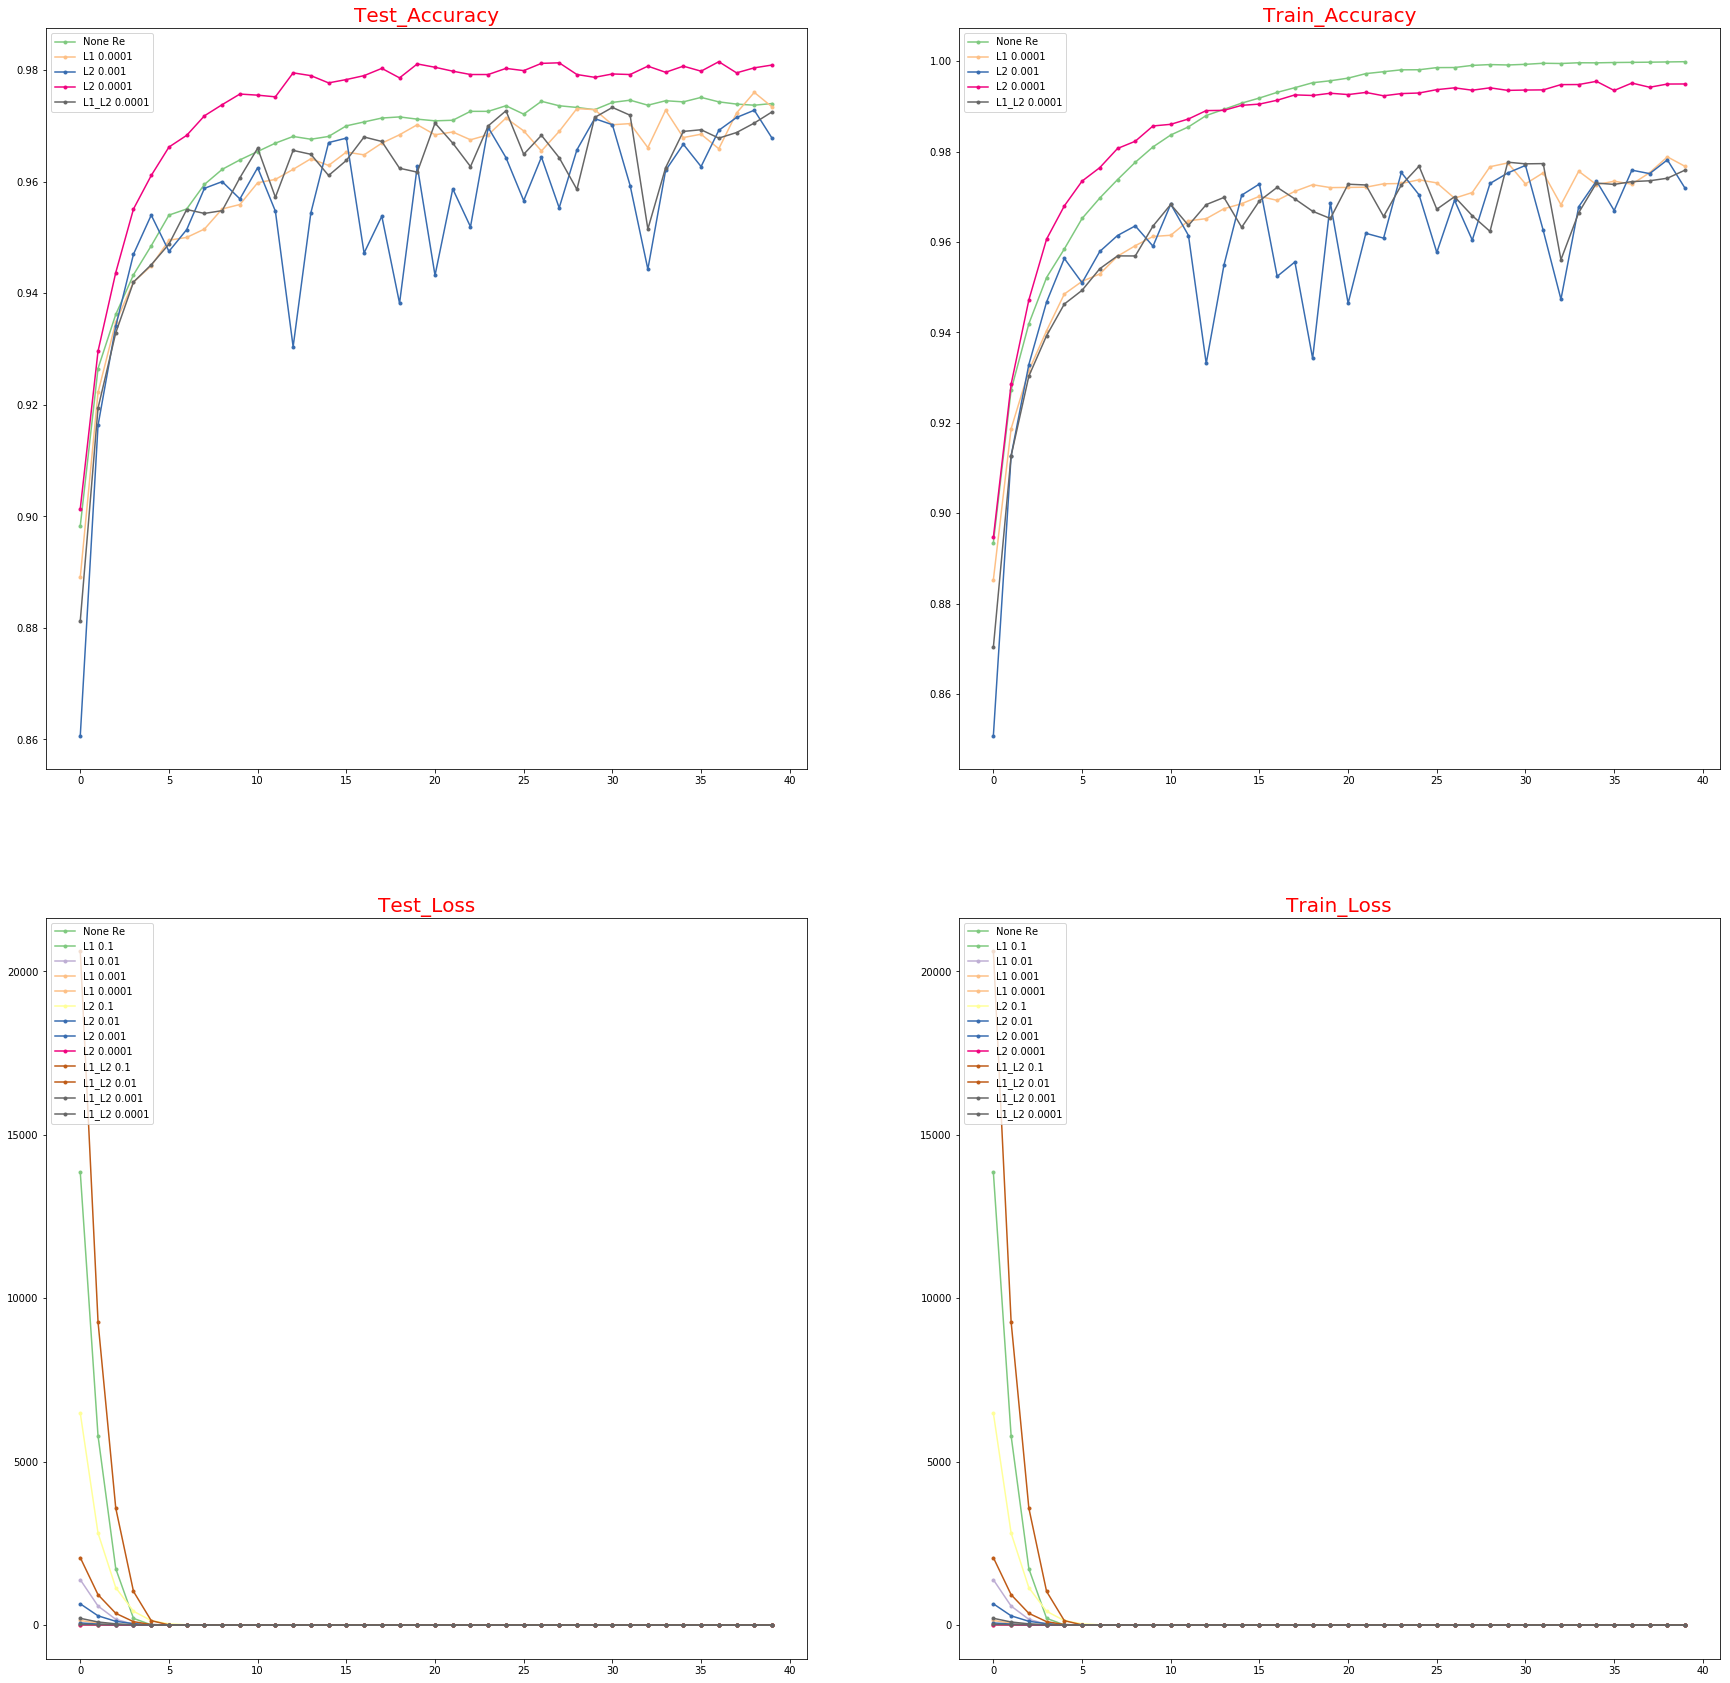

In [66]:
def draw_staticist_data(staticist,ax,key,title,color_map,is_draw_func):
    ax.set_title(title,color='r',fontsize=20)
    color = 'k'
    length = len(staticist["steps"])
    for index,model in enumerate(models):
        if model.name in staticist:                
            color = color_map.to_rgba(index)
            model_data = staticist[model.name]
            if key in model_data:
                if not is_draw_func or is_draw_func(model_data[key]):
                    ax.plot(staticist["steps"],model_data[key],".-",color=color,label=model.name)
    ax.legend(loc=2)

plt.figure(figsize=(30,30))
ax = plt.subplot(2,2,1)
draw_staticist_data(staticist,ax,"test_acc","Test_Accuracy",color_map,lambda datas: np.mean(datas)>0.9)
ax = plt.subplot(2,2,2)
draw_staticist_data(staticist,ax,"train_acc","Train_Accuracy",color_map,lambda datas: np.mean(datas)>0.9)
ax = plt.subplot(2,2,3)
draw_staticist_data(staticist,ax,"test_loss","Test_Loss",color_map,None)
ax = plt.subplot(2,2,4)
draw_staticist_data(staticist,ax,"train_loss","Train_Loss",color_map,None)
plt.show()